In [20]:
#constants

DATA_PATH = 'C:\\Users\\gt\\End to End Data Science Project\\Processed data\\preprocessed_data.pkl'
FEATURES_PATH = 'C:\\Users\\gt\\End to End Data Science Project\\Processed data\\features_skills_clusters.pkl'

EXPORT_FEATURES_DIR = "C:\\Users\\gt\\End to End Data Science Project\\Processed data"
FIG_DIR = "C:\\Users\\gt\\End to End Data Science Project\\Reports"
TRANSPARENT_STRING = 'rgba(0, 0, 0, 0)'
NA_string='Not Specified'
ROLE_COLS = ['DevType']
TECH_COLS = ['LanguageHaveWorkedWith',
             'DatabaseHaveWorkedWith',
             'PlatformHaveWorkedWith',
             'WebframeHaveWorkedWith', 
             'MiscTechHaveWorkedWith', 
             'ToolsTechHaveWorkedWith', 
             'NEWCollabToolsHaveWorkedWith']

In [21]:
#Load pachages
import pandas as pd
import numpy as np
import logging
import pickle
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score


import plotly.express as px
import os
import seaborn as sns
import plotly.graph_objects as go
import matplotlib.pyplot as plt

## Read data and preprocess data


<br>

In [22]:
# Read Data 
processed_df = pd.read_pickle(DATA_PATH)
features_df =pd.read_pickle(FEATURES_PATH)
features_df

,skills_group_0,skills_group_1,skills_group_10,skills_group_11,skills_group_2,skills_group_3,skills_group_4,skills_group_5,skills_group_6,skills_group_7,skills_group_8,skills_group_9
0,1,1,0,0,2,0,0,0,4,0,4,0
1,3,3,0,0,4,1,0,1,1,0,1,0
2,12,0,0,0,2,0,0,1,1,1,0,0
3,0,0,0,0,4,0,0,0,0,0,0,0
4,6,4,0,0,2,1,0,1,0,2,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...
83434,0,3,0,0,1,0,1,3,2,1,1,0
83435,4,2,1,0,3,4,1,4,4,1,4,1
83436,8,7,0,0,2,1,0,5,3,1,0,3
83437,8,5,0,0,6,0,0,1,0,1,0,3


In [23]:
#Onehot encode
df=processed_df.copy()
encoded_dfs={}
for col in ROLE_COLS+TECH_COLS:
    Binarizer = MultiLabelBinarizer()
    encoded_df=pd.DataFrame(Binarizer.fit_transform(df[col]),
                            columns=Binarizer.classes_,
                           index=df[col].index)

    encoded_dfs[col]=encoded_df
df = pd.concat(encoded_dfs, axis=1)    
df.head()

DevType                           \
  Academic researcher Data or business analyst   
0                   0                        0   
1                   0                        0   
2                   0                        0   
3                   0                        0   
4                   0                        0   

                                                                        \
  Data scientist or machine learning specialist Database administrator   
0                                             0                      0   
1                                             0                      0   
2                                             0                      0   
3                                             0                      0   
4                                             0                      0   

                                                                        \
  Designer DevOps specialist Developer, QA or test Developer, back-end   
0        0                 0                     0                   0   
1        0                 0                     0                   0   
2        0                 0                     0                   0   
3        0                 0                     0                   0   
4        0                 0                     0                   0   

                                                 \
  Developer, desktop or enterprise applications   
0                                             0   
1                                             0   
2                                             0   
3                                             0   
4                                             1   

                                               ...  \
  Developer, embedded applications or devices  ...   
0                                           0  ...   
1                                           0  ...   
2                                           0  ...   
3                                           0  ...   
4                                           0  ...   

  NEWCollabToolsHaveWorkedWith                                           \
                       RStudio Rider RubyMine Sublime Text TextMate Vim   
0                            0     0        0            0        0   0   
1                            0     0        0            0        0   0   
2                            1     0        0            1        0   0   
3                            0     0        0            0        0   0   
4                            0     0        0            0        0   1   

                                                   
  Visual Studio Visual Studio Code Webstorm Xcode  
0             0                  0        0     1  
1             0                  0        0     0  
2             0                  1        0     0  
3             0                  0        0     0  
4             0                  0        0     0  

[5 rows x 150 columns]

## Quick sanity check
Checking that there is no problems in our processed data and clustering data

In [24]:
# Select random int (row number)
i = np.random.randint(processed_df.shape[0])

# Print original values
print(processed_df.iloc[i][ROLE_COLS].tolist())
print(processed_df.iloc[i][TECH_COLS].tolist())
print("----------------")

# Print processed
print(df.iloc[i][df.iloc[i] == 1])
print("----------------")

print("Skills:",  df[TECH_COLS].iloc[i].sum())
print("Clusters:",features_df.iloc[i].sum())


[['Developer, back-end', 'Academic researcher']]
[['HTML/CSS', 'JavaScript', 'Node.js', 'Python', 'SQL'], ['MySQL', 'PostgreSQL', 'SQLite'], ['AWS', 'Heroku'], ['Django', 'Express', 'Flask'], ['NumPy'], ['Git'], ['Visual Studio Code']]
----------------
DevType                       Academic researcher    1
                              Developer, back-end    1
LanguageHaveWorkedWith        HTML/CSS               1
                              JavaScript             1
                              Node.js                1
                              Python                 1
                              SQL                    1
DatabaseHaveWorkedWith        MySQL                  1
                              PostgreSQL             1
                              SQLite                 1
PlatformHaveWorkedWith        AWS                    1
                              Heroku                 1
WebframeHaveWorkedWith        Django                 1
                              Ex

<hr>

# Data Cleaning

## Exclude Roles
Removing unnecessary roles 

Remainder: we are interested in tech roles


<br>

In [25]:
# Exclude roles
EXCULDE_ROLES = [
    'Other (please specify):',
    'Student',
    'Designer',
    'Educator',
    'Marketing or sales professional',
    'Engineering manager',
    'Senior Executive (C-Suite, VP, etc.)',
    'Product manager',
    'Engineer, site reliability']

In [26]:
for role in EXCULDE_ROLES:
    df = df.drop(("DevType", role), axis=1)

In [27]:
# Check the total samples of roles
original_role_sum = df["DevType"].sum(axis=0)
original_role_sum.sort_values(ascending=False)

Developer, full-stack                            32891
Developer, back-end                              29071
Developer, front-end                             18231
Developer, desktop or enterprise applications    11036
Developer, mobile                                 9800
DevOps specialist                                 7058
System administrator                              6079
Database administrator                            5655
Developer, embedded applications or devices       4598
Data scientist or machine learning specialist     4273
Engineer, data                                    4176
Data or business analyst                          3792
Developer, QA or test                             3611
Academic researcher                               2899
Developer, game or graphics                       2112
Scientist                                         2015
dtype: int64

Number of full stack developers is about 10 times the number of Academic researcher and we can notice easily that the data is unbalanced

<hr>


## Filter Data



<br>

In [28]:
df[ROLE_COLS].sum(axis=1) #some people didn't put a role at all in the form

0        1
1        0
2        0
3        1
4        3
        ..
83434    1
83435    1
83436    2
83437    1
83438    3
Length: 83439, dtype: int64

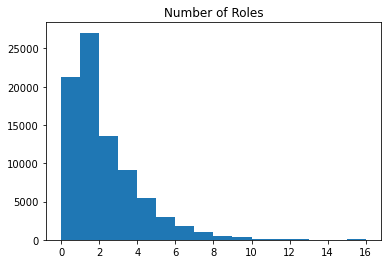

In [29]:
freq_roles = df[ROLE_COLS].sum(axis=1)
plt.hist(freq_roles, freq_roles.max()) #maximum number of roles someone write in the form is 16
plt.title('Number of Roles')
plt.show()

Data is positively skewed and we can see that 14, 15 or 16 roles for example is obviously a noise

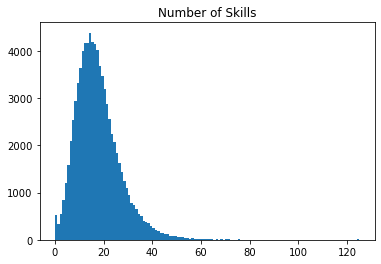

In [30]:
freq_tech = df[TECH_COLS].sum(axis=1)
plt.hist(freq_tech, freq_tech.max())
plt.title('Number of Skills')
plt.show()

It's normally distributed and it also contains noise 

In [31]:
# Filter frequencies 
ROLES_RANGE = [1,3] #setting the maximum number of roles to 3
TECH_RANGE  = [3,30] #setting the maximum number of skills to 30

In [32]:
role_mask   = (freq_roles >= ROLES_RANGE[0]) & (freq_roles <= ROLES_RANGE[1])
tech_mask   = (freq_tech >= TECH_RANGE[0])   & (freq_tech <= TECH_RANGE[1])
filter_mask = role_mask & tech_mask

In [33]:
features_df = features_df.loc[filter_mask].copy()
df = df.loc[filter_mask].copy()

In [34]:
# Check the total samples of roles
cleaned_role_sum = df["DevType"].sum(axis=0)
cleaned_role_sum.sort_values(ascending=False)

Developer, full-stack                            20655
Developer, back-end                              17084
Developer, front-end                              8932
Developer, desktop or enterprise applications     4845
Developer, mobile                                 4751
DevOps specialist                                 3056
Data scientist or machine learning specialist     2460
Developer, embedded applications or devices       2138
System administrator                              2069
Engineer, data                                    1941
Academic researcher                               1708
Data or business analyst                          1658
Database administrator                            1210
Developer, QA or test                             1135
Scientist                                         1046
Developer, game or graphics                        899
dtype: int64

Number of responses in each role decreased but the data is still unbalanced

<hr>

## Merge & Export data

In [35]:
df

DevType                           \
      Academic researcher Data or business analyst   
0                       0                        0   
3                       0                        0   
4                       0                        0   
8                       0                        0   
9                       0                        0   
...                   ...                      ...   
83434                   0                        0   
83435                   0                        0   
83436                   0                        0   
83437                   0                        0   
83438                   0                        0   

                                                                            \
      Data scientist or machine learning specialist Database administrator   
0                                                 0                      0   
3                                                 0                      0   
4                                                 0                      0   
8                                                 0                      0   
9                                                 1                      0   
...                                             ...                    ...   
83434                                             0                      0   
83435                                             0                      0   
83436                                             1                      0   
83437                                             0                      0   
83438                                             0                      0   

                                                                   \
      DevOps specialist Developer, QA or test Developer, back-end   
0                     0                     0                   0   
3                     0                     0                   0   
4                     0                     0                   0   
8                     0                     0                   0   
9                     0                     0                   0   
...                 ...                   ...                 ...   
83434                 0                     0                   1   
83435                 0                     0                   0   
83436                 1                     0                   0   
83437                 0                     0                   1   
83438                 0                     0                   1   

                                                     \
      Developer, desktop or enterprise applications   
0                                                 0   
3                                                 0   
4                                                 1   
8                                                 0   
9                                                 0   
...                                             ...   
83434                                             0   
83435                                             0   
83436                                             0   
83437                                             0   
83438                                             0   

                                                                        ...  \
      Developer, embedded applications or devices Developer, front-end  ...   
0                                               0                    0  ...   
3                                               0                    1  ...   
4                                               0                    0  ...   
8                                               0                    1  ...   
9                                               0                    0  ...   
...                                           ...                  ...  ...   
83434                                           0     

In [36]:
# Add second level indexing 
features_df.columns = pd.MultiIndex.from_product([['skills_clusters'], 
                                                  features_df.columns])

In [37]:
df = pd.concat([df, features_df], axis=1)
df.shape

(46412, 153)

In [38]:
df.to_pickle(EXPORT_FEATURES_DIR+'\\cleaned_data.pkl')
